Comparison of below encordings with random forest and final comparison with catboost
* Label Encoding
* One Hot Encoding
* Hash Encoding
* K-fold Target Encoding
* Ordered Target Encoding

In [523]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [347]:
import time
import random
import matplotlib.pyplot as plt
import string
from utils import *
from sklearn.datasets import *
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [257]:
import catboost
from catboost import CatBoostClassifier

# Dataset 1. 
Simulated dataset with one feature. 10,000 data points, 100 level cardinality. Rule: Ones starting with vowel have target label 1 and others have target label 0

### Creating simulated dataset

In [473]:
random.seed(10)
catvar = []
for i in range(100):
    random_str = ''.join([random.choice(string.ascii_letters) for n in range(5)])
    catvar.append(random_str)
catvar[:10]

['KcBEK',
 'anDFr',
 'PZkcH',
 'FuepV',
 'xcAiM',
 'wyAsR',
 'qDlRt',
 'QxiDX',
 'pCNyc',
 'Lapim']

In [474]:
# training and testing data
np.random.seed(10)
train_data = np.random.choice(catvar, size=10000)
np.random.seed(11)
test_data = np.random.choice(catvar, size=1000)

In [475]:
# strings starting with vowels are positive
# train
label_train_list = [c.lower().startswith(("a","e","i","o","u")) for c in train_data]
label_train_list = np.array(label_train_list).astype(int)
# test
label_test_list = [c.lower().startswith(("a","e","i","o","u")) for c in test_data]
label_test_list = np.array(label_test_list).astype(int)

In [476]:
train_data_df = pd.DataFrame({"x": train_data, "y": label_train_list})
test_data_df = pd.DataFrame({"x": test_data, "y": label_test_list})
train_data_df.head()

,x,y
0,Lapim,0
1,QeIfj,0
2,MUtbL,0
3,HEMFe,0
4,tczMW,0


In [477]:
sum(label_train_list)/len(label_train_list), sum(label_test_list)/len(label_test_list)

(0.208, 0.211)

Both test and train have around 20% positive labels with a little bit of difference

### Model comparisons

In [541]:
encoders = {"one_hot": one_hot_encoder, 
            "numeric_label": label_encoder,
            "hash": hash_encoder, 
            "kfold_target": kfold_target_encoder, 
            "catboost_target_encoder": catboost_target_encoder}

In [542]:
train_scores = {}
test_scores = {}
times = {}
for enc_name, enc in encoders.items():
    train_score = 0.
    test_score = 0.
    st = time.time()
    for i in range(10):  # for measuring times
        train_score_this_iter, test_score_this_iter = fitmodel_and_auc_score(enc, 
                                                                             train_data_df, 
                                                                             test_data_df, ["x"], "y") 
        train_score+=train_score_this_iter
        test_score+=test_score_this_iter
    # averaging score
    train_score/=10.
    test_score/=10.
    times[enc_name] = time.time()-st    
    train_scores[enc_name] = train_score
    test_scores[enc_name] = test_score

In [543]:
# now fitting on catboost
cat_features=[0]
train_score = 0.
test_score = 0.
st = time.time()
for i in range(10):
    model = CatBoostClassifier(
        iterations=500,
        early_stopping_rounds=20)

    model.fit(
        train_data_df["x"], train_data_df["y"],
        cat_features=cat_features,
        eval_set=(test_data_df["x"], test_data_df["y"]),
        verbose=False
    )
    
    train_score_this_iter = roc_auc_score(train_data_df.y, model.predict(train_data_df.x))
    test_score_this_iter = roc_auc_score(test_data_df.y, model.predict(test_data_df.x))
    train_score+=train_score_this_iter
    test_score+=test_score_this_iter
    # averaging score
train_score/=10.
test_score/=10.
times["catboost"] = time.time()-st    
train_scores["catboost"] = train_score
test_scores["catboost"] = test_score

In [544]:
train_scores

{'one_hot': 0.9963942307692308,
 'numeric_label': 1.0,
 'hash': 0.9690656565656568,
 'kfold_target': 1.0,
 'catboost_target_encoder': 0.9951923076923077,
 'catboost': 1.0}

In [545]:
test_scores

{'one_hot': 0.9947867298578199,
 'numeric_label': 1.0,
 'hash': 0.9670468948035487,
 'kfold_target': 1.0,
 'catboost_target_encoder': 1.0,
 'catboost': 1.0}

In [546]:
times

{'one_hot': 10.497339248657227,
 'numeric_label': 11.937826156616211,
 'hash': 13.738202810287476,
 'kfold_target': 9.657154083251953,
 'catboost_target_encoder': 9.620632886886597,
 'catboost': 63.245049238204956}

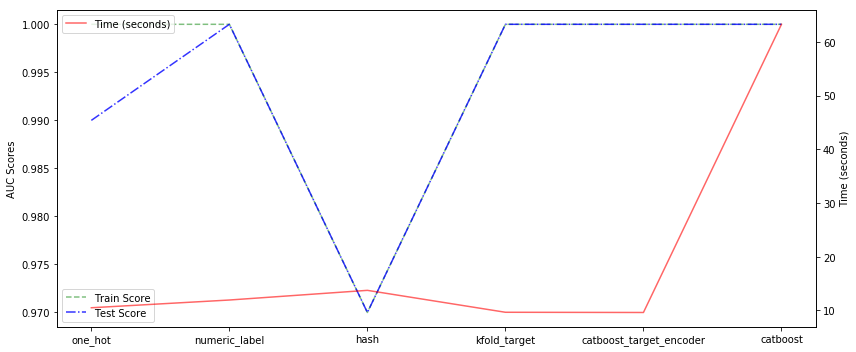

In [547]:
fig, ax = plt.subplots(1,1,figsize=(12,5))

ax2 = ax.twinx()
ax.plot(train_scores.keys(), [round(t,2) for t in train_scores.values()], "--", color="g", alpha=0.5)
ax.plot(test_scores.keys(), [round(t,2) for t in test_scores.values()],  "-.", color="b", alpha=0.8)
ax2.plot(times.keys(), [round(t,2) for t in times.values()], color="r", alpha=0.6)
ax2.set_xlabel("Encoders")
ax.set_ylabel("AUC Scores")
ax2.set_ylabel("Time (seconds)")
ax2.yaxis.tick_right()
ax.legend(["Train Score", "Test Score"])
ax2.legend(["Time (seconds)"])

fig.tight_layout()

# Dataset 2
Amazon.com - Employee Access Challenge data. Contains all categorical variables with different cardinalities. 
https://www.kaggle.com/c/amazon-employee-access-challenge

### Loading dataset

In [485]:
from catboost.datasets import amazon

In [486]:
train, test = amazon()

In [487]:
# cardinality
train.apply(lambda x: len(x.unique()))

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

In [551]:
7518/train.shape[0], 67/train.shape[0]

(0.22942415087430193, 0.002044615337666697)

In [488]:
# ROLE_CODE == ROLE_TITLE
# removing one 
train.drop("ROLE_TITLE", axis=1, inplace=True)
test.drop("ROLE_TITLE", axis=1, inplace=True)

In [489]:
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,308574,118539
2,1,36724,14457,118219,118220,117884,267952,19721,117880
3,1,36135,5396,117961,118343,119993,240983,290919,118322
4,1,42680,5905,117929,117930,119569,123932,19793,119325


In [490]:
print("Ones", round(sum(train.ACTION == 1)/len(train),2))
print("Zeros", round(sum(train.ACTION == 0)/len(train),2))

Ones 0.94
Zeros 0.06


In [491]:
train.shape

(32769, 9)

In [492]:
0.8*train.shape[0]

26215.2

In [493]:
# Randomly splitting train-test data (80,20)
np.random.seed(10)
train_sub = train.iloc[np.random.permutation(train.index)[:26215],:].reset_index(drop=True)
valid_sub = train.iloc[np.random.permutation(train.index)[26215:],:].reset_index(drop=True)

In [494]:
train_sub.shape, valid_sub.shape

((26215, 9), (6554, 9))

In [495]:
train_sub.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78382,7001,117961,118327,118933,132108,4673,121596
1,1,74508,17561,91261,118026,118202,118260,290919,118261
2,1,17249,4914,117961,118300,120026,133686,118424,119435
3,1,971,3918,117961,118343,118660,250337,118424,120791
4,1,17171,1810,117961,118327,120559,117906,290919,117908


### Modeling

1. Data is already numeric label encoded. So no need for that. 

In [548]:
encoders = {"one_hot": one_hot_encoder, 
            "numeric_label": None,
            "kfold_target": kfold_target_encoder, 
            "catboost_target_encoder": catboost_target_encoder}

In [549]:
targetfeatures = ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
                  'ROLE_DEPTNAME', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

In [534]:
train_scores = {}
test_scores = {}
times = {}
for enc_name, enc in encoders.items():
    train_score = 0.
    test_score = 0.
    st = time.time()
    for i in range(1):  # just running once as this data is large
        train_score_this_iter, test_score_this_iter = fitmodel_and_auc_score(enc, 
                                                                             train_sub, 
                                                                             valid_sub,
                                                                             targetfeatures, 
                                                                             "ACTION") 
        train_score+=train_score_this_iter
        test_score+=test_score_this_iter
    # averaging score
    train_score/=1.
    test_score/=1.
    times[enc_name] = time.time()-st    
    train_scores[enc_name] = train_score
    test_scores[enc_name] = test_score

In [535]:
# now fitting on catboost
cat_features=range(8)
train_score = 0.
test_score = 0.
st = time.time()
for i in range(1):
    model = CatBoostClassifier(
        iterations=500,
        early_stopping_rounds=20, 
        eval_metric="AUC")

    model.fit(
        train_sub[targetfeatures], train_sub["ACTION"],
        cat_features=cat_features,
        eval_set=(valid_sub[targetfeatures], valid_sub["ACTION"]),
        verbose=False
    )
    
    train_score_this_iter = roc_auc_score(train_sub.ACTION, model.predict(train_sub[targetfeatures]))
    test_score_this_iter = roc_auc_score(valid_sub.ACTION, model.predict(valid_sub[targetfeatures]))
    train_score+=train_score_this_iter
    test_score+=test_score_this_iter
    # averaging score
train_score/=1.
test_score/=1.
times["catboost"] = time.time()-st    
train_scores["catboost"] = train_score
test_scores["catboost"] = test_score

In [536]:
train_scores

{'one_hot': 0.7323405414477682,
 'numeric_label': 0.8617465313668865,
 'kfold_target': 0.878025396681621,
 'catboost_target_encoder': 0.8418819465905094,
 'catboost': 0.9062952227704307}

In [537]:
test_scores

{'one_hot': 0.7137792512590169,
 'numeric_label': 0.8418601468103788,
 'kfold_target': 0.849442427403292,
 'catboost_target_encoder': 0.818754352716162,
 'catboost': 0.8715391293807279}

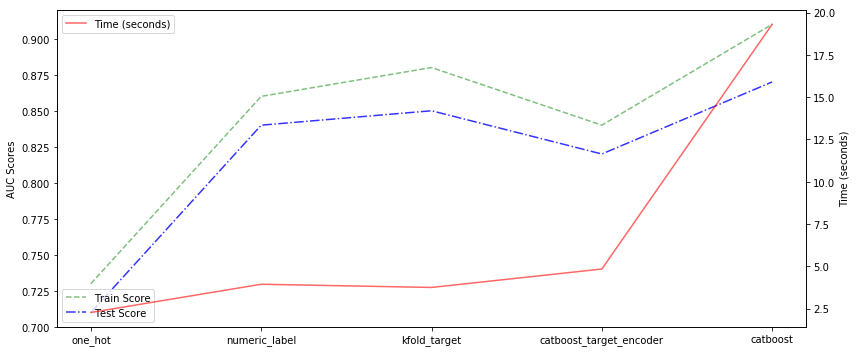

In [538]:
fig, ax = plt.subplots(1,1,figsize=(12,5))

ax2 = ax.twinx()
ax.plot(train_scores.keys(), [round(t,2) for t in train_scores.values()], "--", color="g", alpha=0.5)
ax.plot(test_scores.keys(), [round(t,2) for t in test_scores.values()],  "-.", color="b", alpha=0.8)
ax2.plot(times.keys(), [round(t,2) for t in times.values()], color="r", alpha=0.6)
ax2.set_xlabel("Encoders")
ax.set_ylabel("AUC Scores")
ax2.set_ylabel("Time (seconds)")
ax2.yaxis.tick_right()
ax.legend(["Train Score", "Test Score"], loc="lower left")
ax2.legend(["Time (seconds)"])

fig.tight_layout()

## End